### Creating a tensor 
(like ```NumPy.ndarray```)

In [1]:
import torch
import numpy as np

data = [[1, 2],[3, 4]]
torch.tensor(data)

tensor([[1, 2],
        [3, 4]])

### Loading datasets

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    # target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    # target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

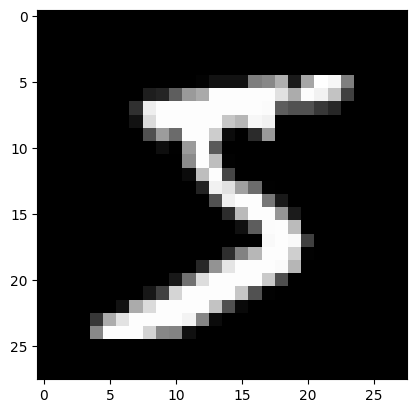

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

i = 0
data, label = training_data[i]
data = data.reshape((28, 28))

plt.imshow(data, cmap='gray')
plt.show()

# img = Image.fromarray(255 * data.numpy()).convert("L")
# display(img)

### Neural network construction

In [4]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x) # 2D to 1D input
        logits = self.linear_relu_stack(x) # Neural network layers
        return logits # Final output
    
    
# class Mnist_CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
#         self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
#         self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

#     def forward(self, xb):
#         xb = xb.view(-1, 1, 28, 28)
#         xb = F.relu(self.conv1(xb))
#         xb = F.relu(self.conv2(xb))
#         xb = F.relu(self.conv3(xb))
#         xb = F.avg_pool2d(xb, 4)
#         return xb.view(-1, xb.size(1))

lr = 0.1
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Example run with 1 input data

In [6]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X) # 2D array of outputs (dim=0) and individual values of each output (dim=1)
pred_probab = nn.Softmax(dim=1)(logits) # Converts to a probability amplitude (normalization)
y_pred = pred_probab.argmax(1) # Gets maximum probability
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1])


### Back propagation
using ```torch.autograd```

Inside the training loop, optimization happens in three steps:
* Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
* Backpropagate the prediction loss with a call to `loss.backward()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.
* Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

In [7]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Loss Function

In [8]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

[Optimizers](https://pytorch.org/docs/stable/optim.html)

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302346  [    0/60000]
loss: 2.304604  [ 6400/60000]
loss: 2.290633  [12800/60000]
loss: 2.287872  [19200/60000]
loss: 2.280988  [25600/60000]
loss: 2.280408  [32000/60000]
loss: 2.267185  [38400/60000]
loss: 2.282729  [44800/60000]
loss: 2.265456  [51200/60000]
loss: 2.248088  [57600/60000]
Test Error: 
 Accuracy: 41.2%, Avg loss: 2.255135 

Epoch 2
-------------------------------
loss: 2.253543  [    0/60000]
loss: 2.252153  [ 6400/60000]
loss: 2.251847  [12800/60000]
loss: 2.225836  [19200/60000]
loss: 2.228175  [25600/60000]
loss: 2.228032  [32000/60000]
loss: 2.205345  [38400/60000]
loss: 2.238328  [44800/60000]
loss: 2.201232  [51200/60000]
loss: 2.182041  [57600/60000]
Test Error: 
 Accuracy: 63.3%, Avg loss: 2.188731 

Epoch 3
-------------------------------
loss: 2.187288  [    0/60000]
loss: 2.179158  [ 6400/60000]
loss: 2.191605  [12800/60000]
loss: 2.135399  [19200/60000]
loss: 2.147136  [25600/60000]
loss: 2.143727  [32000/600

### Saving and loading the model

In [12]:
torch.save(model.state_dict(), 'model_weights.pth')

In [13]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

Alternate syntax to also store model structure

In [14]:
torch.save(model, 'model.pth')

In [15]:
model = torch.load('model.pth')